# 6. 학습 관련 기술

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [72]:
import numpy as np
import matplotlib.pyplot as plt


# 계단 함수 구현 
def step_function(x) :
    y = x > 0
    return y.astype(np.int64)


# sigmoid 함수 구현
def sigmoid(x) :
    return 1 / (1 + np.exp(-x))


# ReLU 함수 구현
def ReLU(x) :
    return np.maximum(0,x)


# 항등 함수 구현현
def identity_function(x) :
    return x


# softmax함수 구현
def softmax(a) :
    c = np.max(a)
    exp_a = np.exp(a - c)     # 오버플로우 방지
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y
    
    
# 크로스 앤트로피 구현
def cross_entropy(y,t) :
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))




# 수치 미분  구현 
def numerical_gradient(f, x):
    h = 1e-7 # 0.0000001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad




# 곱셈 계층 구현현
class MulLayer :
    def __init__(self) :
        self.x = None
        self.y = None

    # x와 y를 인수로 받고 두 값을 곱해서 반환.
    def forward(self, x, y) :
        self.x = x
        self.y = y
        out = x * y

        return out
        
    # 상류에서 넘어온 미분(dout)에 순전파때의 값을 서로 바꿔 곱한 후 하류로 흘림.
    def backward(self, dout) :
        dx = dout * self.y    # change x with y
        dy = dout * self.x

        return dx, dy




# 덧셈 계층
#backward()에서 상류에서 내려온 미분을 그대로 하류로 흫림.
class AddLayer :
    def __init__(self) :
        pass
        
    def forward(self, x, y) :
        out = x + y
        return out

    def backward(self, dout) :
        dx = dout * 1
        dy = dout * 1 
        return dx, dy


# reLU 계층 구현현
class Relu :
    def __init__(self) :
        self.mask = None

    def forward(self, x) :
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out

    def backward(self, dout) :
        dout[self.mask] = 0
        dx = dout

        return dx       
    


# sigmoid 계층 구현현
class Sigmoid :
    def __init__(self) :
        self.out = None
        
    def forward(self, x) :
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout) :
        dx = dout * self.out * (1 - self.out)
        return dx



# Affine 계층 구현
class Affine :
    def __init__(self, W, b) :
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x) :
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout) :
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)

        return dx



# softmax_loss 계층을 구현함 
class SoftmaxWithLoss :
    def __init__(self) :
        self.loss = None # 손실
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블(원-핫 벡터)
    
    def forward(self, x, t) :
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy(self.y, self.t)
        return self.loss

    def backward(self, dout = 1) :
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size  # 평균화된 기울기를 구함
        return dx
        



from collections import OrderedDict

class MultiLayerNet :
    def __init__(self, input_size, hidden_size_list, output_size, 
                activation='relu', weight_init_std='relu', weight_decay_lambda=0) :
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화 
        self.__init_weight(weight_init_std)
    
        #계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu' : Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1) :
            self.layers['Affine'+str(idx)] = Affine(self.params['W'+str(idx)],
                                                    self.params['b'+str(idx)])
            self.layers['Activation_function'+str(idx)]=activation_layer[activation]()
        idx = self.hidden_layer_num + 1
        self.layers['Affine'+str(idx)] = Affine(self.params['W'+str(idx)],
                                                self.params['b'+str(idx)])
        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std) :
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)) :
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he') :
                scale = np.sqrt(2.0/all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xaiver') :
                scale = np.sqrt(1.0/all_size_list[idx - 1])
            self.params['W'+str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx]) 
            self.params['b'+str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x) :
        for layer in self.layers.values() :
            x = layer.forward(x)

        return x


    def loss(self, x, t) :
        y = self.predict(x) 
        weight_decay = 0

        for idx in range(1, self.hidden_layer_num + 2) :
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay


    def accuracy(self, x, t) :
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.dim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(len(y.shape[0]))
        return accuracy

    
    #오차역전파
    def gradient(self, x, t) :
        self.loss(x,t) 

        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers :
            dout = layer.backward(dout)

        # 결과 저장 
        grads = {}
        for idx in range(1, self.hidden_layer_num+2) :
            grads['W'+str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b'+str(idx)] = self.layers['Affine' + str(idx)].db

        return grads



## 6.1.2 확률적 경사 하강법(SGD)

In [2]:
# SGD 구현

class SGD :
    def __init__(self, lr = 0.1) :
        self.lr = lr

    def update(self, params, grads) :
        for key in params.keys() :
            params[key] -= self.lr * grads[key]


In [3]:
# psedo code
"""
network = TwoLayerNet()
optimizer = SGD()

for i in range(1000) :
    X_batch, y_batch = get_mini_batch()
    grads = network.gradient(X_batch, y_batch)
    params = network.params
    optimizer.update(params, grads)
"""

'\nnetwork = TwoLayerNet()\noptimizer = SGD()\n\nfor i in range(1000) :\n    X_batch, y_batch = get_mini_batch()\n    grads = network.gradient(X_batch, y_batch)\n    params = network.params\n    optimizer.update(params, grads)\n'

## 6.1.4 Momentum

In [4]:
# Momentum 구현
class Momentum :
    def __init__(self, lr = 0.01, momentum = 0.9) :
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads) :
        if self.v is None :
            self.v = {}
            for key, val in params.items() :
                self.v[key] = np.zeros_like(val)
        for key in params.keys() :
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

## 6.1.6 AdaGrad

In [5]:
# AdaGrad 구현

class AdaGrad :
    def __init__(self, lr = 0.01) :
        self.lr = lr
        self.h = None

    def update(self, params, grads) :
        if (self.h is None) :
            self.h = {}
            for key,value in params.items() :
                self.h[key] = np.zeros_like(value)
                
        for key in params.keys() :
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [6]:
# RMSProp 구현

class RMSProp :
    def __init__(self, lr = 0.01, rho = 0.9) :
        self.lr = lr
        self.rho = rho
        self.r = None

    def update(self, params, grads) :
        delta = 1e-7
        if (self.r is None) :
            self.r = {}
            for key, value in params.items() :
                self.r[key] = np.zeros_like(value)

        for key in params.keys() :
            self.r[key] = self.rho * self.r[key] + (1-self.rho) * grads[key] * grads[key]
            params[key] -=  self.lr / (np.sqrt(self.r[key]) + delta)* grads[key]


In [7]:
# Adam 구현

class Adam :
    def __init__(self, lr = 0.1, rho1 = 0.9, rho2 = 0.999) :
        self.lr = lr
        self.rho1 = rho1
        self.rho2 = rho2
        self.s = None
        self.r = None
        self.k = 0       # iteration

    def update(self, params, grads) :
        delta = 1e-7
        if (self.s is None) :
            self.s = {}
            self.r = {}
            for key, value in params.items() :
                self.s[key] = np.zeros_like(value)
                self.r[key] = np.zeros_like(value)
        self.k += 1
        for key in params.keys() :
            self.s[key] = self.rho1 * self.s[key] + (1 - self.rho1) * grads[key]
            self.r[key] = self.rho2 * self.r[key] + (1 - self.rho2) * grads[key] ** 2
            s_hat = self.s[key] / (1 - self.rho1 ** self.k  )
            r_hat = self.r[key] / (1 - self.rho2 ** self.k  )      
            params[key] -= self.lr / (delta + np.sqrt(r_hat)) * s_hat
        

## 6.1.7 어느 갱신 방법을 이용할 것 인가 ?

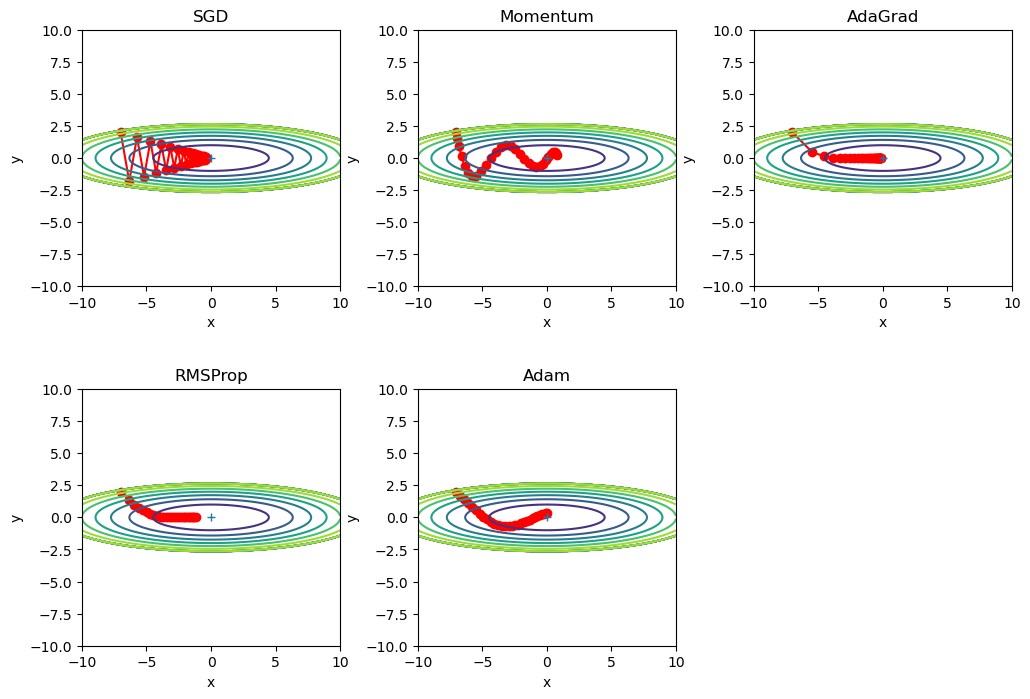

In [8]:
from collections import OrderedDict

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["RMSProp"] = RMSProp(lr= 0.2)
optimizers["Adam"] = Adam(lr=0.3)

plt.figure(figsize=(12, 8))

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 3, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.subplots_adjust(wspace=0.3, hspace=0.4)    
plt.show()

In [9]:
# 보통 Adam을 많이 쓴다.

## 6.2  가중치의 초깃값

In [43]:
from common import *


In [44]:
#입력층은 28*28
#출력층은 10(0~9)
# 첫번째 은닉층은 50개 두번째 은닉층은 100개로 임의로 정함
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# 0으로 채워진 길이 n의 리스트를 반환 
def zeros(n) :
    return [0 for i in range(n)]

# 1차원 넘파이 배열을 2차원 one_hot_enconding으로 반환 
# 주의 근데 여기서만 써야함
def one_hot_encoding_in_one_to_two(y, n) :
    output = []
    for i in y :
        row = zeros(n) 
        row[i] = 1
        output.append(row)
    return np.array(output)

# 주의 4장에서만 사용할 것
def get_data_with_one_hot_encoding() :
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist.data, mnist.target
    y = y.astype(int) 
    X = X.astype(np.float64)  # 나누기를 하기위해 타입변환
    X /= 255.0   #정규화, 0~1값으로 만들기

    y = one_hot_encoding_in_one_to_two(y, 10) # 1차원 넘파이 배열을 2차원 one_hot_enconding으로 반환 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)
    
    return (X_train, y_train), (X_test, y_test)




# 데이터 준비
(X_train, y_train) , (X_test, y_test) = get_data_with_one_hot_encoding()

===========iteration:0===========
SGD:904.5365871956974
Momentum:922.7645917988716
AdaGrad:1215.3417185173892
Adam:2046.9981475717068
RMSProp:2058.93335463662


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2572\4062040917.py:242: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2572\4062040917.py:242: RuntimeWarning: invalid value encountered in scalar multiply
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


===========iteration:100===========
SGD:nan
Momentum:nan
AdaGrad:2063.116243322665
Adam:2063.116243322665
RMSProp:2063.116243322665
===========iteration:200===========
SGD:nan
Momentum:nan
AdaGrad:2046.9981475717068
Adam:2046.9981475717068
RMSProp:2046.9981475717068
===========iteration:300===========
SGD:nan
Momentum:nan
AdaGrad:2046.9981475717068
Adam:2063.116243322665
RMSProp:2063.116243322665
===========iteration:400===========
SGD:nan
Momentum:nan
AdaGrad:2063.116243322665
Adam:2063.116243322665
RMSProp:2063.116243322665
===========iteration:500===========
SGD:nan
Momentum:nan
AdaGrad:2063.116243322665
Adam:2063.116243322665
RMSProp:2063.116243322665
===========iteration:600===========
SGD:nan
Momentum:nan
AdaGrad:2046.9981475717068
Adam:2063.116243322665
RMSProp:2046.9981475717068
===========iteration:700===========
SGD:nan
Momentum:nan
AdaGrad:2063.116243322665
Adam:2063.116243322665
RMSProp:2063.116243322665
===========iteration:800===========
SGD:nan
Momentum:nan
AdaGrad:2063.

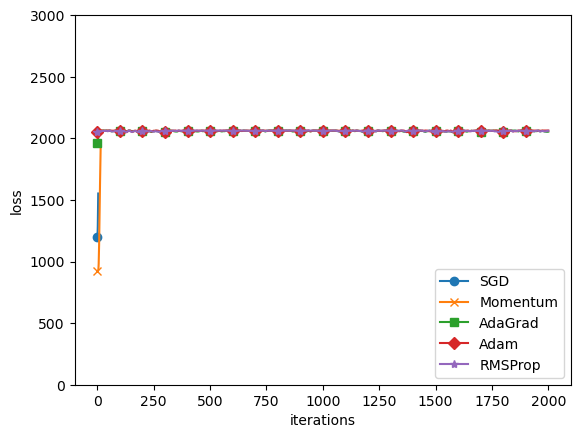

In [80]:

train_size = X_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSProp'] = RMSProp()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = X_train[batch_mask]
    t_batch = y_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========

def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSProp":"*"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 3000)
plt.legend()
plt.show()

## 6.2.2 은닉층의 활성화값 분포

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

In [14]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드수
hidden_layer_size = 5           # 은닉층이 5개  
activations = {}                # 이곳에 활성화값을 저장 (활성화값은 계층상이를 흐르는 데이터)

for i in range(hidden_layer_size) :
    if (i != 0) :
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1 # 이 부분을 바꿔보기
    a = np.dot(x, w) 
    z = sigmoid(a)   #이 부분을 바꿔보기
    activations[i] = z

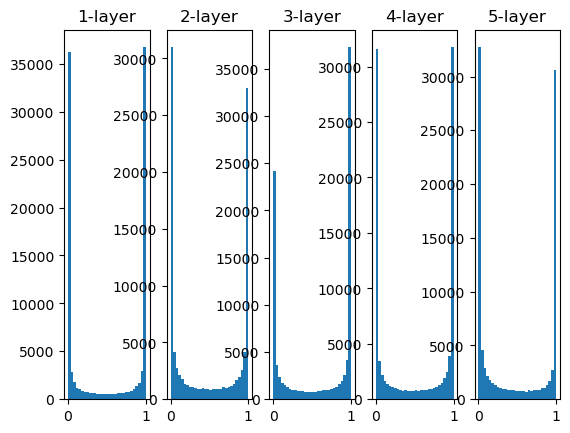

In [15]:
# histogram
for i, a in activations.items() :
    plt.subplot(1, len(activations), i + 1) 
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

In [16]:
### 이번에는 가중치에 0.01을 곱해보기

In [17]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드수
hidden_layer_size = 5           # 은닉층이 5개  
activations = {}                # 이곳에 활성화값을 저장 (활성화값은 계층상이를 흐르는 데이터)

for i in range(hidden_layer_size) :
    if (i != 0) :
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01 # 이 부분을 바꿔보기
    a = np.dot(x, w) 
    z = sigmoid(a)   #이 부분을 바꿔보기
    activations[i] = z

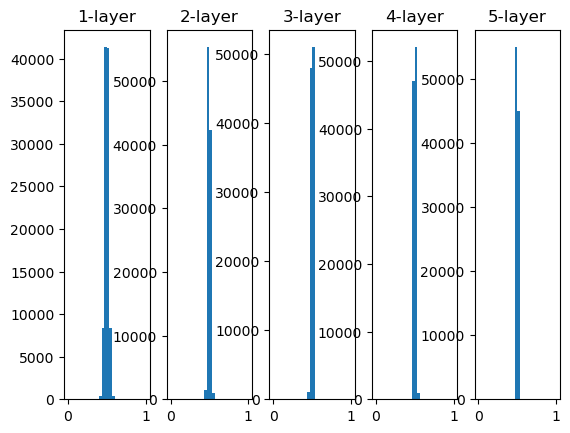

In [18]:
# histogram
for i, a in activations.items() :
    plt.subplot(1, len(activations), i + 1) 
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

### 이번에는 0.5 부근에 집중, 기울기 소실 문제는 사라지지만 활성화값이 치우쳐져 표현력을 제한당함

-> 각층의 활성화값은 적당히 골고루 분포되어야 한다.

## Xaiver 가중치 사용해보기

In [19]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드수
hidden_layer_size = 5           # 은닉층이 5개  
activations = {}                # 이곳에 활성화값을 저장 (활성화값은 계층상이를 흐르는 데이터)

for i in range(hidden_layer_size) :
    if (i != 0) :
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # 이 부분을 바꿔보기
    a = np.dot(x, w) 
    z = sigmoid(a)   #이 부분을 바꿔보기
    activations[i] = z

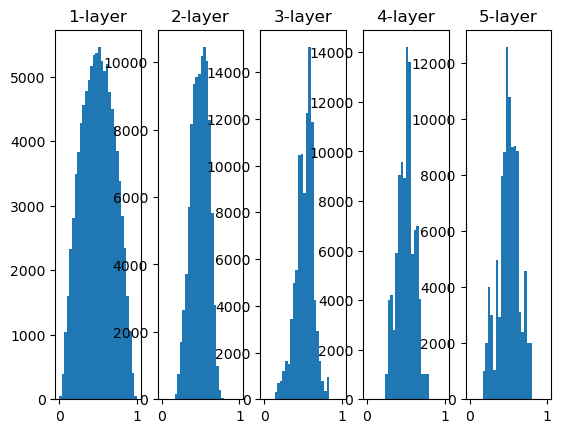

In [20]:
# histogram
for i, a in activations.items() :
    plt.subplot(1, len(activations), i + 1) 
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

### xaiver초깃값 사용결과를 보면 층이 깊어질수록 형태가 다소 일그러지지만 
### 확실히 앞에 것과 비교해 넓게 분포하는 것을 확인할 수 있다.


## 활성화함수로 tanh함수와 초깃값으로는 xaiver로 하기

In [21]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드수
hidden_layer_size = 5           # 은닉층이 5개  
activations = {}                # 이곳에 활성화값을 저장 (활성화값은 계층상이를 흐르는 데이터)

for i in range(hidden_layer_size) :
    if (i != 0) :
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # 이 부분을 바꿔보기
    a = np.dot(x, w) 
    z = tanh(a)   #이 부분을 바꿔보기
    activations[i] = z

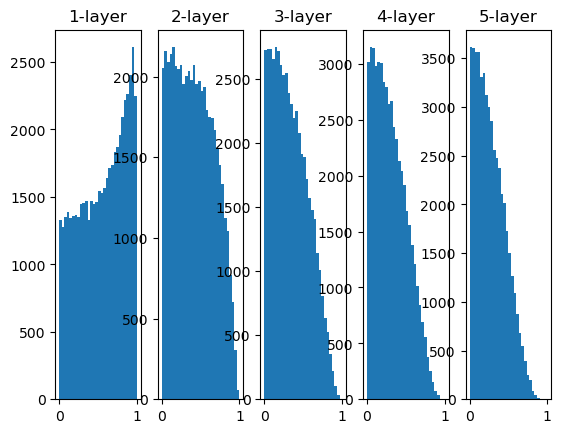

In [22]:
# histogram
for i, a in activations.items() :
    plt.subplot(1, len(activations), i + 1) 
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

### 와우 

## 6.2.3 ReLU를 사용할 때의 가중치 초깃값

## 활성화함수로 ReLU함수와 초깃값으로는 0.01 * 정규분포로 하기

In [23]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드수
hidden_layer_size = 5           # 은닉층이 5개  
activations = {}                # 이곳에 활성화값을 저장 (활성화값은 계층상이를 흐르는 데이터)

for i in range(hidden_layer_size) :
    if (i != 0) :
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01 # 이 부분을 바꿔보기
    a = np.dot(x, w) 
    z = ReLU(a)   #이 부분을 바꿔보기
    activations[i] = z

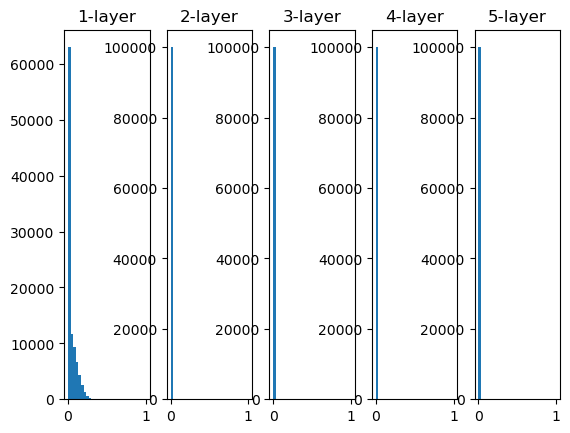

In [24]:
# histogram
for i, a in activations.items() :
    plt.subplot(1, len(activations), i + 1) 
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

In [25]:
## 

## 활성화함수로 ReLU함수와 초깃값으로는 Xaiver로 하기

In [26]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드수
hidden_layer_size = 5           # 은닉층이 5개  
activations = {}                # 이곳에 활성화값을 저장 (활성화값은 계층상이를 흐르는 데이터)

for i in range(hidden_layer_size) :
    if (i != 0) :
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) # 이 부분을 바꿔보기
    a = np.dot(x, w) 
    z = ReLU(a)   #이 부분을 바꿔보기
    activations[i] = z

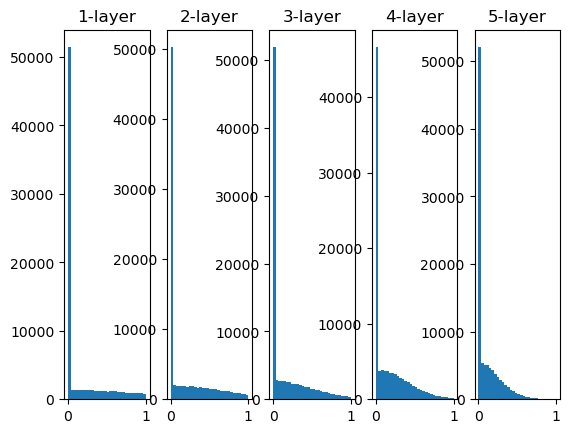

In [27]:
# histogram
for i, a in activations.items() :
    plt.subplot(1, len(activations), i + 1) 
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

In [28]:
##

## 활성화함수로 ReLU함수와 초깃값으로는 He로 하기

In [29]:
x = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100                  # 각 은닉층의 노드수
hidden_layer_size = 5           # 은닉층이 5개  
activations = {}                # 이곳에 활성화값을 저장 (활성화값은 계층상이를 흐르는 데이터)

for i in range(hidden_layer_size) :
    if (i != 0) :
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num/2) # 이 부분을 바꿔보기
    a = np.dot(x, w) 
    z = ReLU(a)   #이 부분을 바꿔보기
    activations[i] = z

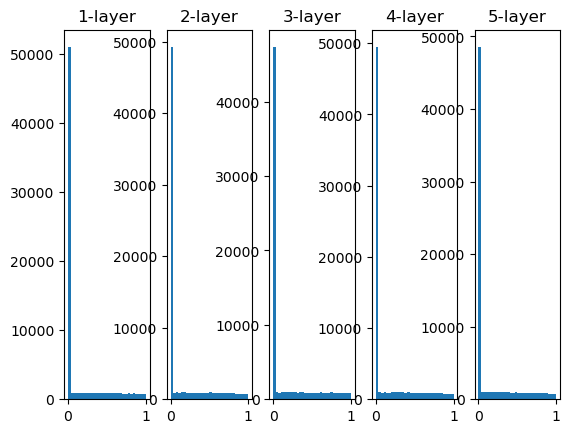

In [30]:
# histogram
for i, a in activations.items() :
    plt.subplot(1, len(activations), i + 1) 
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0,1))
plt.show()

### 층이 깊어져도 모든 층에서 균일하게 분포되었다!

## 배치 정규화

In [ ]:
class BatchNormalization :
    def 

## 6.4.3 드롭아웃

In [91]:
class Dropout :
    def __init__(self, dropout_ratio = 0.5) :
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True) :
        if train_flg :
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else :
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout) :
        return dout * self.mask

## 6.5 적절한 파라미터 값 찾기